# Chargement des données STL10

 STL10 contient 5000 images d'entraînement et 8000 images de test.

In [30]:
# path_to_data = "./STL10_9696"
path_to_data = "./STL10"

In [92]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Transformations basiques sans augmentation
transform_base = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionnement pour le modèle
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisation
])

# Chargement du dataset STL10
# Les images STL10 sont de dimension 96x96.
# trainset = datasets.STL10(root=path_to_data, split='train', download=True, transform=transform_base)
# testset = datasets.STL10(root=path_to_data, split='test', download=True, transform=transform_base)

# print(f"Dataset STL10 chargé: {len(trainset)} images d'entraînement, {len(testset)} images de test")


In [93]:
from google.colab import drive
drive.mount('/content/drive')
path_to_drive_data = "drive/MyDrive/SDD/data_augmentation/STL10"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
trainset = datasets.STL10(root=path_to_drive_data, split='train', download=False, transform=transform_base)
testset = datasets.STL10(root=path_to_drive_data, split='test', download=False, transform=transform_base)

In [95]:
test_loader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [33]:
# trainset = trainset_
# testset = testset_

In [6]:
import matplotlib.pyplot as plt
import numpy as np

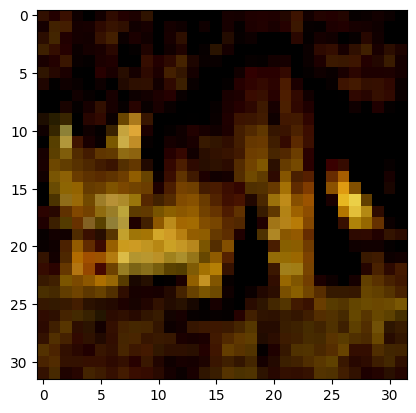

In [7]:
# plt.imshow(trainset[0][0])
plt.imshow(np.transpose(trainset[4][0],(1,2,0)))

# Génération des Politiques d’Augmentation

On convertit la sortie du LSTM en transformations dynamiques.

Seules certaines transformations sont appliquées selon la politique générée.

In [96]:
images_size = trainset[0][0].shape[1] # if 32 : images are squares of 32x32

augmentations = [
    transforms.CenterCrop(size=16),
    transforms.RandomCrop(size=16),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), shear=15),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomInvert(p=0.5),
    transforms.RandomSolarize(-0.1, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
]

In [55]:
def plot_transformed_image(image, transformation) :
  transformed_image = transformation(image)
  plt.imshow(np.transpose(transformed_image, (1,2,0)))

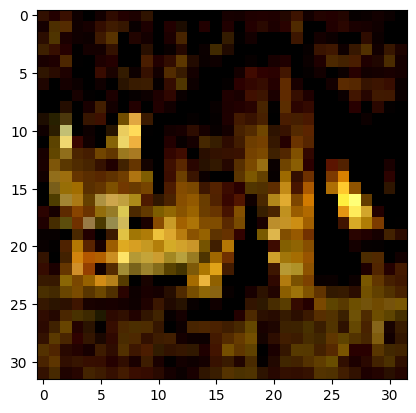

In [87]:
plot_transformed_image(trainset[4][0], augmentations[11])

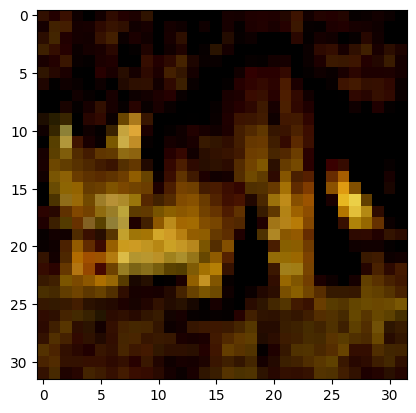

In [21]:
plt.imshow(np.transpose(transforms.CenterCrop(size=32)(trainset[4][0]), (1,2,0)))

In [97]:
import random

def apply_augmentations(image,
                        policy,
                        replace : bool, # this argument is used to specify if the data should be replaced by the augmented data or enriched.
                        augmentations
                        ):
    image_aug = image

    for i, aug in enumerate(augmentations):
        if policy[i] > 0.5:  # Seuil pour activer une transformation
            image_aug = aug(image)
    if replace :
        return image_aug
    else :
        return image, image_aug


# Définition de l'agent LSTM

Ce LSTM prend en entrée un vecteur aléatoire et génère une politique d'augmentation.

Ce LSTM génère une politique d'augmentation sous forme de 5 nombres entre 0 et 1.

In [36]:
torch.cuda.is_available()

True

In [98]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class AutoAugmentLSTM(nn.Module):
    def __init__(self, input_size=10, hidden_size=128, num_layers=2, output_size=len(augmentations)):
        super(AutoAugmentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # 5 valeurs pour 5 types d'augmentation

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Dernière sortie de la séquence
        return torch.sigmoid(out)  # Convertir en probabilités entre 0 et 1

lstm = AutoAugmentLSTM().to(device)
# lstm = AutoAugmentLSTM().cuda()


# Modèle Proxy pour Tester les Augmentations

On entraîne un CNN léger (ResNet18) sur les données augmentées.

Ce modèle proxy nous permet de tester si une politique d’augmentation améliore l'entraînement.

In [100]:
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models

### Un proxy simplissime

Performances :

    RUN_0 :
        images 32x32
        batch_size=64
        20%|██        | 1/5 [00:51<03:27, 51.93s/it] Epoch [1/5], Loss: 1.7010
        num_worker=8

In [64]:
input_size = 32*32  # images are 32x32 pixels
output_size = 10  # there are 10 classes
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
proxy_model=SimpleCNN().to(device)

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Définition du modèle
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Première couche de convolution : entrée 3 canaux (RGB), sortie 32 filtres 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # MaxPooling 2x2 pour réduire la taille de l'image
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Couche entièrement connectée :
        # L'entrée doit correspondre à la taille après convolutions + pooling
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)  # 64 cartes de 8x8
        self.fc2 = nn.Linear(in_features=128, out_features=10)  # 10 classes
        # Placeholder pour fc1 (on ajustera dynamiquement)
        # self.fc1 = nn.Linear(1, 128)  # Placebo, on corrigera après
        # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution + ReLU + MaxPooling
        # print(f"Taille après convolutions et pooling: {x.shape}")

        x = x.view(x.size(0), -1)  # Mise à plat (Flatten)
        # print(f"Taille après flatten: {x.shape}")
        x = F.relu(self.fc1(x))  # Couche entièrement connectée + ReLU
        x = self.fc2(x)  # Dernière couche (sortie brute, non normalisée)

        return x

# Vérification du modèle
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
proxy_model=SimpleCNN().to(device)
print(proxy_model)  # Affichage de la structure du modèle


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [59]:
print(proxy_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


### Un proxy moins simple

In [101]:
import torchvision.models as models
proxy_model = models.resnet18(num_classes=10).to(device)

In [102]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(proxy_model.parameters(), lr=0.001)

def train_proxy_model(train_loader, model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [103]:
def evaluate_proxy_model(model, test_loader):
    model.eval()
    with torch.no_grad() :
      correct = 0
      total = 0
      total_loss = 0.0

      for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = total_loss /len(test_loader)
    return accuracy, avg_loss

# Boucle de Recherche pour Optimiser l’AutoAugment

On entraîne le LSTM en mettant à jour ses poids en fonction de l'amélioration des performances du modèle proxy.

Perfromances :

    RUN_0 :
        images 96x96
        batch_size=128
        60%|██████    | 3/5 [02:47<01:52, 56.39s/it]Epoch [3/5], Loss: 1.1865
        num_worker=4

    RUN_1 :
        images 32x32
        batch_size=128
        num_worker=4
        40%|████      | 2/5 [01:55<02:53, 57.88s/it]

    RUN_2 :
        images 32x32
        batch_size=64
        num_worker=4
        40%|████      | 2/5 [02:05<03:07, 62.54s/it]

    RUN_3 :
        images 32x32
        batch_size=64
        num_worker=8
        20%|██        | 1/5 [01:00<04:00, 60.17s/it] Epoch [1/5], Loss: 1.1175

    RUN_4 :
        images 32x32
        batch_size=64
        num_worker=8
        20%|██        | 1/5 [01:01<04:06, 61.54s/it] Epoch [1/5], Loss: 0.9135

In [109]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr=0.001)
loss_lstm = nn.MSELoss()  # Comparaison avec l'amélioration attendue

baseline_accuracy = 0.0

for iteration in range(2):  # Nombre d'itérations de recherche
    lstm_input = torch.randn(1, 10, 10).to(device)  # Entrée aléatoire
    policy = lstm(lstm_input).detach().cpu().numpy()[0]  # Convertir en numpy

    # Appliquer la politique générée
    trainset_augmented = datasets.STL10(root=path_to_drive_data, split='train', download=False,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((32, 32)),
                                            transforms.Normalize((0.5,), (0.5,)),
                                            lambda img: apply_augmentations(img, policy, replace=True, augmentations=augmentations)])
                                        # transform = transforms.ToTensor()
                                        )

    train_loader_aug = DataLoader(trainset_augmented, batch_size=128, shuffle=True, num_workers=4)

    # Entraîner le modèle proxy avec la politique d'augmentation actuelle
    train_proxy_model(train_loader_aug, proxy_model, criterion, optimizer)

    # Évaluer la précision après augmentation
    accuracy_after, avg_loss = evaluate_proxy_model(proxy_model, test_loader)

    # Calculer la récompense et mettre à jour le LSTM
    reward = accuracy_after - baseline_accuracy
    loss = loss_lstm(torch.tensor([reward], dtype=torch.float32).to(device), lstm(lstm_input))
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()

    print(f"Iteration {iteration}, Reward: {reward:.4f}")


 20%|██        | 1/5 [00:05<00:22,  5.52s/it]

Epoch [1/5], Loss: 1.3976


 40%|████      | 2/5 [00:12<00:19,  6.66s/it]

Epoch [2/5], Loss: 1.4370


 60%|██████    | 3/5 [00:18<00:12,  6.12s/it]

Epoch [3/5], Loss: 1.3517


 80%|████████  | 4/5 [00:25<00:06,  6.47s/it]

Epoch [4/5], Loss: 1.3718


100%|██████████| 5/5 [00:30<00:00,  6.20s/it]

Epoch [5/5], Loss: 1.2983


Iteration 0, Reward: 0.4875


 20%|██        | 1/5 [00:05<00:22,  5.73s/it]

Epoch [1/5], Loss: 1.2482


 40%|████      | 2/5 [00:12<00:19,  6.48s/it]

Epoch [2/5], Loss: 1.1429


 60%|██████    | 3/5 [00:18<00:11,  5.99s/it]

Epoch [3/5], Loss: 1.0773


 80%|████████  | 4/5 [00:25<00:06,  6.49s/it]

Epoch [4/5], Loss: 1.1384


100%|██████████| 5/5 [00:31<00:00,  6.20s/it]

Epoch [5/5], Loss: 1.1581


Iteration 1, Reward: 0.4979


# Application de la Meilleure Politique Trouvée

Une fois la meilleure politique identifiée, on applique la meilleure politique trouvée et on entraîne un modèle final performant.

In [110]:
def find_best_policy(lstm):
    """
    Extrait la meilleure politique d'augmentation trouvée après l'entraînement du LSTM.

    Args:
        lstm (torch.nn.Module): Le réseau LSTM entraîné.

    Returns:
        best_policy (list): Liste des transformations correspondant à la meilleure politique.
    """
    lstm.eval()

    with torch.no_grad():
        # Initialisation du LSTM (ex: état caché nul)
        hidden = None
        input_tensor = torch.zeros(1, 1, 10).to(next(lstm.parameters()).device)  # Format d'entrée attendu

        best_policy = []

        # Générer la séquence d'augmentations
        for _ in range(5):  # On suppose une séquence de 5 transformations max
            output, hidden = lstm(input_tensor, hidden)

            # Convertir la sortie en un index de transformation
            transformation_idx = torch.argmax(output, dim=-1).item()

            # Ajouter la transformation correspondante
            best_policy.append(transformation_list[transformation_idx])

            # Mettre à jour l'entrée pour le LSTM
            input_tensor = output.unsqueeze(0)

    return best_policy


In [114]:
torch.zeros(1, 1, 10).to(next(lstm.parameters()).device).shape[-1]

10

In [111]:
best_policy = find_best_policy(lstm)  # Fonction qui extrait la meilleure politique


TypeError: AutoAugmentLSTM.forward() takes 2 positional arguments but 3 were given

In [88]:
best_policy = find_best_policy(lstm)  # Fonction qui extrait la meilleure politique
print(f"Meilleure politique trouvée : {best_policy}")

# Appliquer aux données finales
transform_final = lambda img: apply_augmentations(img, best_policy)
trainset_final = datasets.STL10(root="./data", split='train', download=True, transform=transform_final)
train_loader_final = DataLoader(trainset_final, batch_size=128, shuffle=True, num_workers=4)

# Entraîner le modèle final (ex: WideResNet)
final_model = WideResNet(depth=28, width=10, num_classes=10).cuda()
optimizer_final = optim.SGD(final_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_final_model(train_loader_final, final_model, criterion, optimizer_final)

NameError: name 'find_best_policy' is not defined

# CNN

In [ ]:
# from simple_cnn import SimpleCNN
# import torch.nn as nn
# import torch.optim as optim

# # Initialisation du modèle
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN().to(device)

# # Fonction de perte et optimiseur
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Entraînement du modèle sur les données brutes
# for epoch in range(10):  # Petit entraînement pour test
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

# print("✅ Modèle entraîné sur données brutes !")
